## Logisitic Regression classifier with L2 Regularization

### Load the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from matplotlib import style

### Logistic Regression Classifier

In [2]:
class LogisticRegression(object):
    def __init__(self, learningRate, numIterations = 10, penalty = None, C = 0.01):    
        self.learningRate = learningRate
        self.numIterations = numIterations
        self.penalty = penalty
        self.C = C
    ## END

    def train(self, X_train, y_train, tol = 10 ** -4):
        # Value indicating the weight change between epochs in which gradient descent should terminated. Defaults to 10 ** -4
        tolerance = tol * np.ones([1, np.shape(X_train)[1] + 1])
        self.weights = np.zeros(np.shape(X_train)[1] + 1) 
        X_train = np.c_[np.ones([np.shape(X_train)[0], 1]), X_train]
        self.costs = []

        for i in range(self.numIterations):    
            z = np.dot(X_train, self.weights)
            errors = y_train - sigmoid_function(z)
            if self.penalty is not None:                
                delta_w = self.learningRate * (self.C * np.dot(errors, X_train) + np.sum(self.weights))  
            else:
                delta_w = self.learningRate * np.dot(errors, X_train)
            
            self.iterationsPerformed = i

            if np.all(abs(delta_w) >= tolerance): 
                self.weights += delta_w                                
                if self.penalty is not None:
                    self.costs.append(reg_logLiklihood(X_train, self.weights, y_train, self.C))
                else:
                    self.costs.append(logLiklihood(z, y_train))
            else:
                break
        return self
    ## END
    
    def predict(self, X_test, pi = 0.5):
        z = self.weights[0] + np.dot(X_test, self.weights[1:])        
        probs = np.array([sigmoid_function(i) for i in z])
        predictions = np.where(probs >= pi, 1, 0)
        return predictions, probs
    ## END
    
    def performanceEval(self, predictions, y_test):
        TP, TN, FP, FN, P, N = 0, 0, 0, 0, 0, 0
        
        for idx, test_sample in enumerate(y_test):    
            if predictions[idx] == 1 and test_sample == 1:
                TP += 1       
                P += 1
            elif predictions[idx] == 0 and test_sample == 0:                
                TN += 1
                N += 1
            elif predictions[idx] == 0 and test_sample == 1:
                FN += 1
                P += 1
            elif predictions[idx] == 1 and test_sample == 0:
                FP += 1
                N += 1
            
        accuracy = (TP + TN) / (P + N)    
        sensitivity = TP / P
        specificity = TN / N
        PPV = TP / (TP + FP)
        NPV = TN / (TN + FN)
        FNR = 1 - sensitivity
        FPR = 1 - specificity
        performance = {'Accuracy': accuracy,
                       'Sensitivity': sensitivity,
                       'Specificity': specificity,
                       'Precision': PPV,
                       'NPV': NPV,
                       'FNR': FNR,
                       'FPR': FPR}
        return performance
    ## END
    
    def predictionPlot(self, X_test, y_test):
        zs = self.weights[0] + np.dot(X_test, self.weights[1:])        
        probs = np.array([sigmoid_function(i) for i in zs])    
        plt.figure()
        plt.plot(np.arange(-10, 10, 0.1), sigmoid_function(np.arange(-10, 10, 0.1)))        
        colors = ['r','b']
        probs = np.array(probs)
        for idx,cl in enumerate(np.unique(y_test)):
            plt.scatter(x = zs[np.where(y_test == cl)[0]],
                        y = probs[np.where(y_test == cl)[0]],
                        alpha = 0.8,
                        c = colors[idx],
                        marker = 'o',
                        label = cl,
                        s = 30)
        plt.xlabel('z')
        plt.ylim([-0.1, 1.1])
        plt.axhline(0.0, ls = 'dotted', color = 'k')
        plt.axhline(1.0, ls = 'dotted', color = 'k')
        plt.axvline(0.0, ls = 'dotted', color = 'k')
        plt.ylabel('$\phi (z)$')
        plt.legend(loc = 'upper left')
        plt.title('Logistic Regression Prediction Curve')
        plt.show()
    ## END
    
    def plotCost(self):
        plt.figure()
        plt.plot(np.arange(1, self.iterationsPerformed + 1), self.costs, marker = '.')
        plt.xlabel('Iterations')
        plt.ylabel('Log-Liklihood J(w)')
    ## END
    
    def plotDecisionRegions(self, X_test, y_test, pi = 0.5, res = 0.01):
        x = np.arange(min(X_test[:,0]) - 1, max(X_test[:,0]) + 1, 0.01)
        y = np.arange(min(X_test[:,1]) - 1, max(X_test[:,1]) + 1, 0.01)        
        xx, yy = np.meshgrid(x, y, indexing = 'xy')
        
        data_points = np.transpose([xx.ravel(), yy.ravel()])
        preds, probs = self.predict(data_points, pi)
            
        colors = ['r','b']        
        probs = np.array(probs)
                
        for idx,cl in enumerate(np.unique(y_test)):
            plt.scatter(x = X_test[:,0][np.where(y_test == cl)[0]],
                        y = X_test[:,1][np.where(y_test == cl)[0]],
                        alpha = 0.8,
                        c = colors[idx],
                        marker = 'o',
                        label = cl,
                        s = 30)
            
        preds = preds.reshape(xx.shape)
        plt.contourf(xx, yy, preds, alpha = 0.3)
        plt.legend(loc = 'best')
        plt.xlabel('$x_1$', size = 'x-large')
        plt.ylabel('$x_2$', size = 'x-large')
    ## END
## END

## Utility Functions ##
def sigmoid_function(args):
    return (1/(1 + np.exp(-args)))
## END

def log_function(n):
    return np.log(n)
## END

def logLiklihood(z, y):
    """Log-liklihood function (cost function to be minimized in logistic regression classification)"""
    return -1 * np.sum((y * np.log(sigmoid_function(z))) + ((1 - y) * np.log(1 - sigmoid_function(z))))
## END

def reg_logLiklihood(x, weights, y, C):
    """
    Regularizd log-liklihood function
    (cost function to minimized in logistic regression classification with L2 regularization)
    """
    z = np.dot(x, weights) 
    reg_term = (1 / (2 * C)) * np.dot(weights.T, weights)
    return -1 * np.sum((y * np.log(sigmoid_function(z))) + ((1 - y) * np.log(1 - sigmoid_function(z)))) + reg_term
## END

### Breast Cancer Winconsin Dataset Description

In [3]:
dataset_description = open("./datasets/breast-cancer-wisconsin.names")
print(dataset_description.read())

Citation Request:
   This breast cancer databases was obtained from the University of Wisconsin
   Hospitals, Madison from Dr. William H. Wolberg.  If you publish results
   when using this database, then please include this information in your
   acknowledgements.  Also, please cite one or more of:

   1. O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear 
      programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

   2. William H. Wolberg and O.L. Mangasarian: "Multisurface method of 
      pattern separation for medical diagnosis applied to breast cytology", 
      Proceedings of the National Academy of Sciences, U.S.A., Volume 87, 
      December 1990, pp 9193-9196.

   3. O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition 
      via linear programming: Theory and application to medical diagnosis", 
      in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying
      Li, editors, SIAM Publications, Philadelphia 199

### Import Breast Cancer Wisconsin dataset
### Change the column and index names for the dataset.  

In [4]:
df = pd.read_csv("datasets/breast-cancer-wisconsin.data", header = None)
df.rename(columns = {0:"id", 
                     1:"clump-thickness", 
                     2:"cell-size", 
                     3:"cell-shape", 
                     4:"marginal-adhesion", 
                     5:"epithelial-cell-size", 
                     6:"bare-nuclei", 
                     7:"bland-chromatin", 
                     8:"normal-nucleoli", 
                     9:"mitoses", 
                     10:"class"}, 
          inplace = True)

### Print the first 10 rows of the dataset

In [5]:
df.head(10)

,id,clump-thickness,cell-size,cell-shape,marginal-adhesion,epithelial-cell-size,bare-nuclei,bland-chromatin,normal-nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


### Count the number of values present within the class column of the dataset

In [6]:
df['class'].value_counts()
# 2 is for benign cancer
# 4 is for malignant cancer

2    458
4    241
Name: class, dtype: int64

### Create the feature and label vectors

In [7]:
label_vector = df.iloc[:, 10]   #class labels: 2 = benign, 4 = malignant
feature_vector = df.iloc[:, 1:10] #features vectors
feature_vector

,clump-thickness,cell-size,cell-shape,marginal-adhesion,epithelial-cell-size,bare-nuclei,bland-chromatin,normal-nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1
...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1
695,2,1,1,1,2,1,1,1,1
696,5,10,10,3,7,3,8,10,2
697,4,8,6,4,3,4,10,6,1


### Encode the label values to the binary values (0 and 1)
fit_transform(X, y=None, **fit_params)  

Fit to data, then transform it.  
Fits transformer to X and y with optional parameters fit_params and returns a transformed version of X.  

Parameters  
    X:  {array-like, sparse matrix, dataframe} of shape (n_samples, n_features)  
    y:  ndarray of shape (n_samples,), default=None. Target values.  

Returns  
    X_new:  ndarray array of shape (n_samples, n_features_new)
            Transformed array.

In [8]:
# positive class = 1 (malignant(4)), negative class = 0 (benign(2))
encoder = LabelEncoder()
label_vector = encoder.fit_transform(label_vector)
print("label_vector has {} values".format(np.size(label_vector)))
label_vector

label_vector has 699 values


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,

### Replace missing feature values with mean feature value

In [9]:
feature_vector = feature_vector.replace('?', np.nan)
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(feature_vector)
features = imr.transform(feature_vector.values)

# feature_vector.fillna(value=feature_vector.mean())

### Split data into training (70%) and testing (30%) sets

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(features, label_vector, test_size = 0.3, random_state = 2020)

print("shape of input training data:",X_train.shape)
print("shape of output training data:",Y_train.shape)
print("shape of input testing data:",X_test.shape)
print("shape of output testing data:",Y_test.shape)

shape of input training data: (489, 9)
shape of output training data: (489,)
shape of input testing data: (210, 9)
shape of output testing data: (210,)


### sklearn.preprocessing.StandardScaler() 
It removes the mean and scales each feature/variable to unit variance.
This operation is performed feature-wise in an independent way.  
It can be influenced by outliers (if they exist in the dataset) since it involves the estimation of the empirical mean and standard deviation of each feature.

transform(X[, copy]): Perform standardization by centering and scaling  
fit_transform(X[, y]): Fit to data, then transform it.

In [11]:
#Z-score normalization
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

### Principle component analysis (dimensionality reduction)

In [12]:
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

### Training logistic regression classifier with L2 penalty

In [13]:
LR = LogisticRegression(learningRate = 0.01, numIterations = 20, penalty = "L2", C = 0.01)
LR.train(X_train_pca, Y_train, tol = 10 ** -3) # tol=0.001

### Testing fitted model on test data with cutoff probability 50%

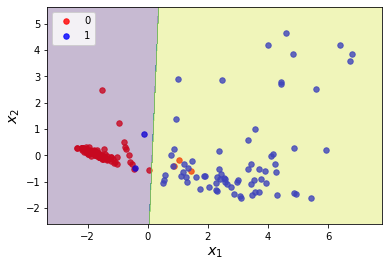

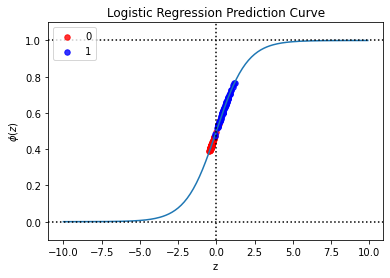

In [14]:
predictions, probs = LR.predict(X_test_pca, 0.5)
performance = LR.performanceEval(predictions, Y_test)
LR.plotDecisionRegions(X_test_pca, Y_test)
LR.predictionPlot(X_test_pca, Y_test)

### Print out performance values

In [15]:
for key, value in performance.items():
    print('%s : %.2f' % (key, value))

Accuracy : 0.98
Sensitivity : 0.97
Specificity : 0.98
Precision : 0.96
NPV : 0.99
FNR : 0.03
FPR : 0.02


### Training logistic regression classifier with No penalty

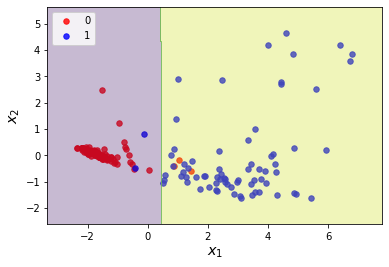

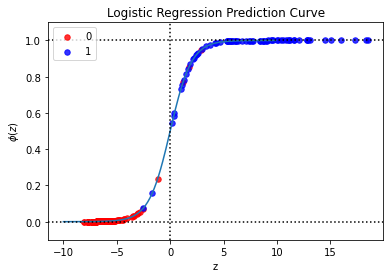

In [16]:
LR = LogisticRegression(learningRate = 0.01, numIterations = 20, penalty = None, C = 0.01)
LR.train(X_train_pca, Y_train, tol = 10 ** -3) # tol=0.001
predictions, probs = LR.predict(X_test_pca, 0.5)
performance = LR.performanceEval(predictions, Y_test)
LR.plotDecisionRegions(X_test_pca, Y_test)
LR.predictionPlot(X_test_pca, Y_test)

In [17]:
for key, value in performance.items():
    print('%s : %.2f' % (key, value))

Accuracy : 0.98
Sensitivity : 0.97
Specificity : 0.98
Precision : 0.96
NPV : 0.99
FNR : 0.03
FPR : 0.02
